In [ ]:
%load_ext autoreload
%autoreload 2

In [102]:
import os

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml

import motorlab as ml

In [ ]:
os.chdir(Path().resolve().parent)

In [ ]:
config_path = "config/pose_to_position/20250701155654.yaml"
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

In [ ]:
model = ml.model.create_model(
    config,
    is_train=False,
)

In [ ]:
data_dict = ml.data.load_all(config)
intervals = ml.utils.extract_intervals(
    config
)  # returns test, train, validation
all_intervals = {session: [] for session in data_dict.keys()}

for tier_intervals in intervals:
    for session in tier_intervals:
        all_intervals[session].extend(tier_intervals[session])

In [ ]:
grads = {session: [] for session in all_intervals}

for session in all_intervals:
    d = data_dict[session]["poses"]
    for s, e in all_intervals[session]:
        x = torch.tensor(d[s:e], device=ml.utils.device, dtype=torch.float32)
        x.requires_grad_(True)
        pred = model(x, session)  # shape: [T, 2]

        grad_list = []
        for i in range(pred.shape[-1]):  # usually 2
            g = torch.autograd.grad(
                outputs=pred[:, i],
                inputs=x,
                grad_outputs=torch.ones_like(pred[:, i]),
                retain_graph=True,
            )[0]  # shape: [T, input_dim]
            grad_list.append(g)

        grad = torch.stack(grad_list, dim=0)  # shape: [2, T, input_dim]
        grads[session].append(grad.detach().cpu().numpy())

In [ ]:
binned_com = dict()
binned_grads = dict()

for session in config["sessions"]:
    poses = ml.data.load_from_memmap(
        Path(config["DATA_DIR"]) / session / "poses"
    )
    com = ml.poses.compute_com(poses, "gbyk")
    bins = ml.room.get_tile(com[:, 0], com[:, 1])
    trial_bins = []
    for i, (s, e) in enumerate(all_intervals[session]):
        labels = bins[s:e].astype(int)
        unique_labels = np.unique(labels)
        means = {}
        for label in unique_labels:
            mask = labels == label
            means[label] = grads[session][i][:, mask].mean(axis=1)

        trial_bins.append(bins[s:e])
    binned_com[session] = np.concatenate(trial_bins, axis=0)

(2, 257, 63) (257,)
(2, 235, 63) (235,)
(2, 278, 63) (278,)
(2, 283, 63) (283,)
(2, 278, 63) (278,)
(2, 274, 63) (274,)
(2, 254, 63) (254,)
(2, 305, 63) (305,)
(2, 268, 63) (268,)
(2, 270, 63) (270,)
(2, 296, 63) (296,)
(2, 303, 63) (303,)
(2, 292, 63) (292,)
(2, 291, 63) (291,)
(2, 315, 63) (315,)
(2, 303, 63) (303,)
(2, 268, 63) (268,)
(2, 254, 63) (254,)
(2, 266, 63) (266,)
(2, 241, 63) (241,)
(2, 248, 63) (248,)
(2, 271, 63) (271,)
(2, 286, 63) (286,)
(2, 295, 63) (295,)
(2, 251, 63) (251,)
(2, 242, 63) (242,)
(2, 259, 63) (259,)
(2, 262, 63) (262,)
(2, 279, 63) (279,)
(2, 250, 63) (250,)
(2, 255, 63) (255,)
(2, 256, 63) (256,)
(2, 265, 63) (265,)
(2, 310, 63) (310,)
(2, 290, 63) (290,)
(2, 255, 63) (255,)
(2, 248, 63) (248,)
(2, 268, 63) (268,)
(2, 255, 63) (255,)
(2, 276, 63) (276,)
(2, 276, 63) (276,)
(2, 270, 63) (270,)
(2, 258, 63) (258,)
(2, 261, 63) (261,)
(2, 243, 63) (243,)
(2, 268, 63) (268,)
(2, 265, 63) (265,)
(2, 254, 63) (254,)
(2, 266, 63) (266,)
(2, 257, 63) (257,)


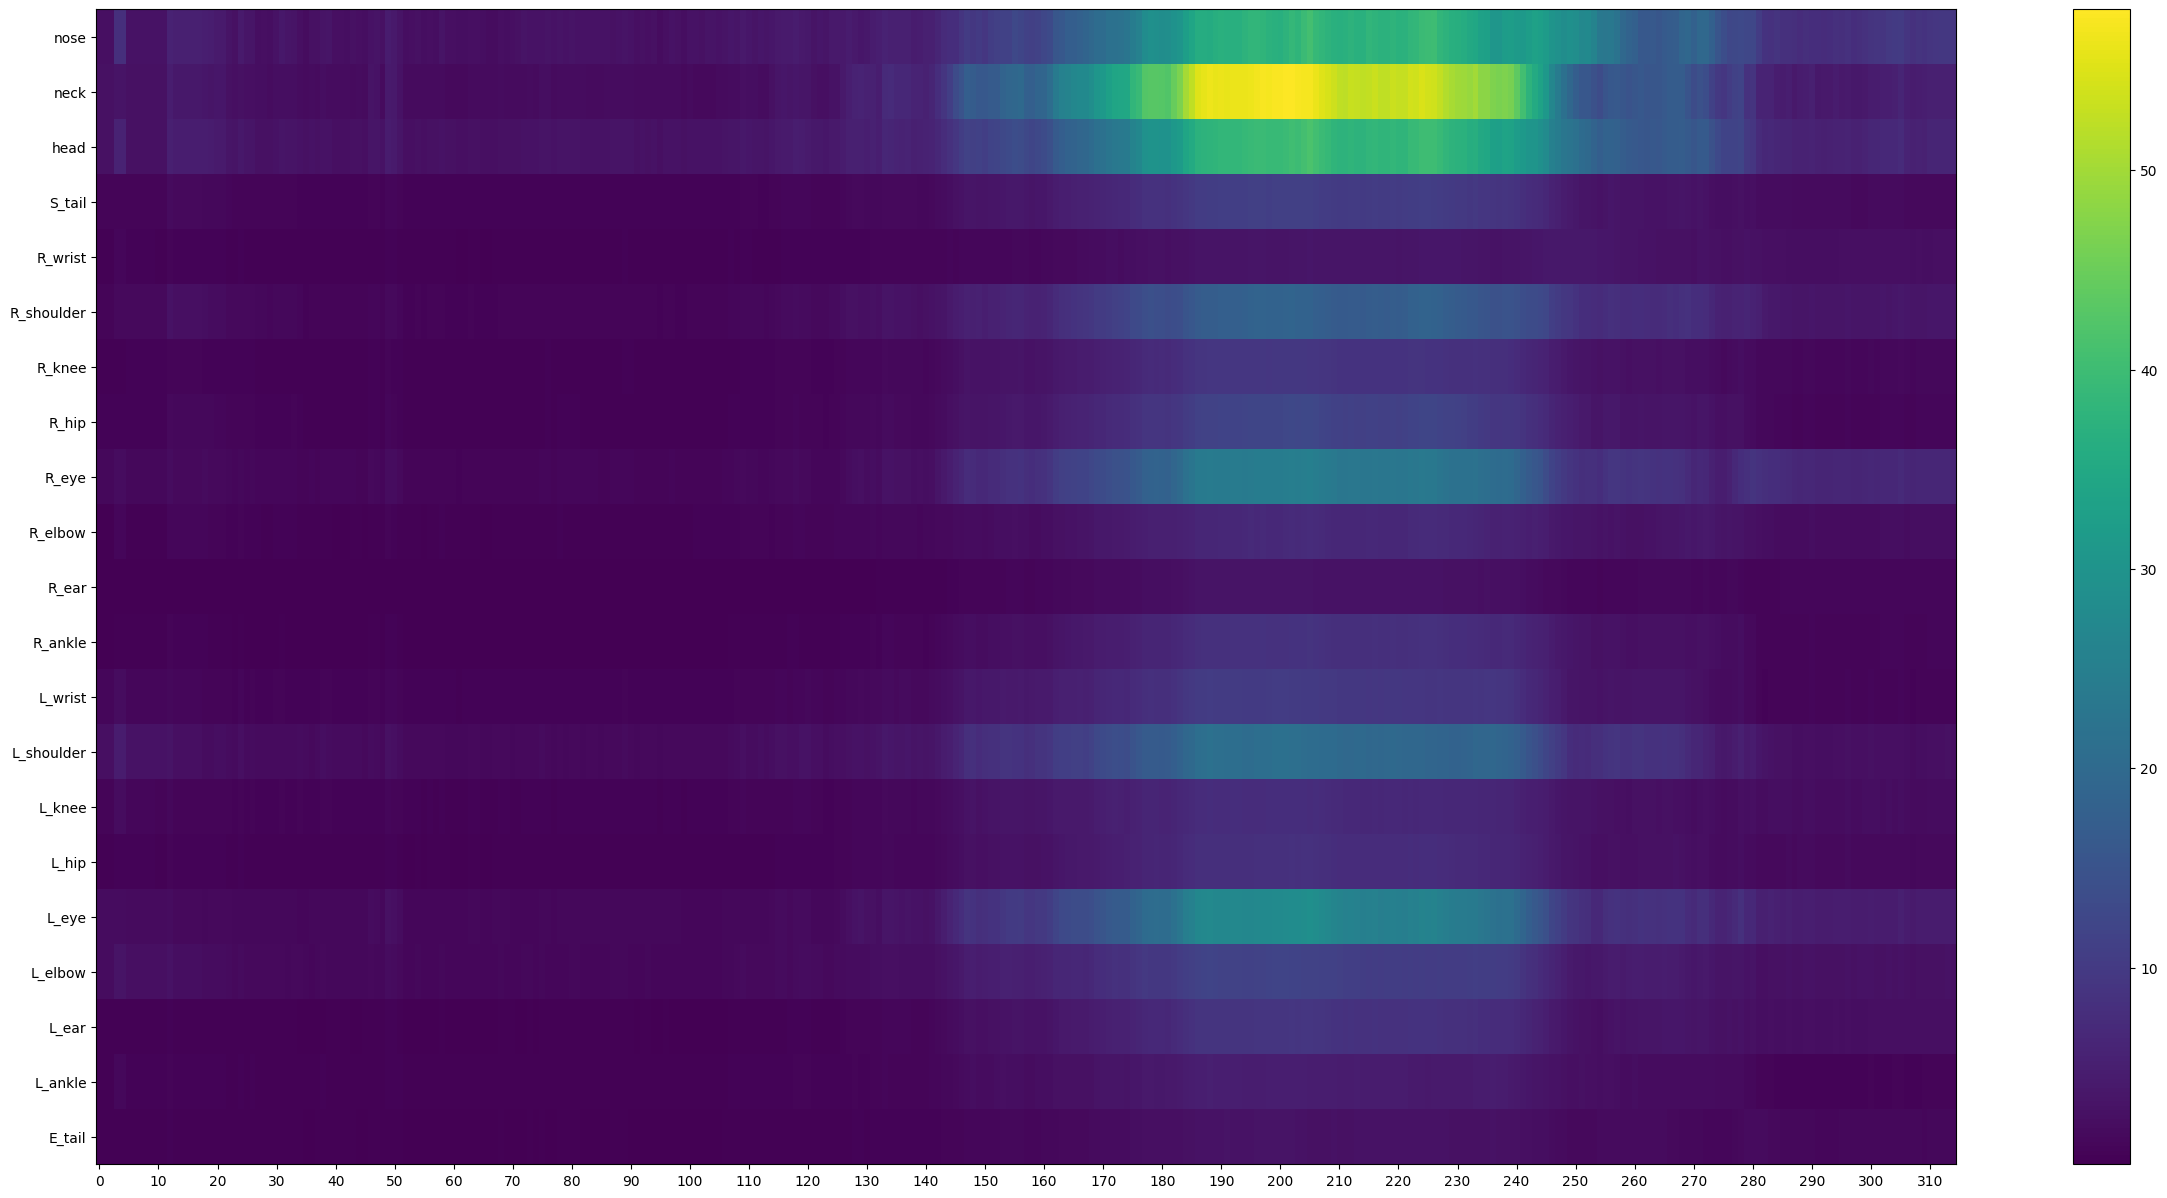

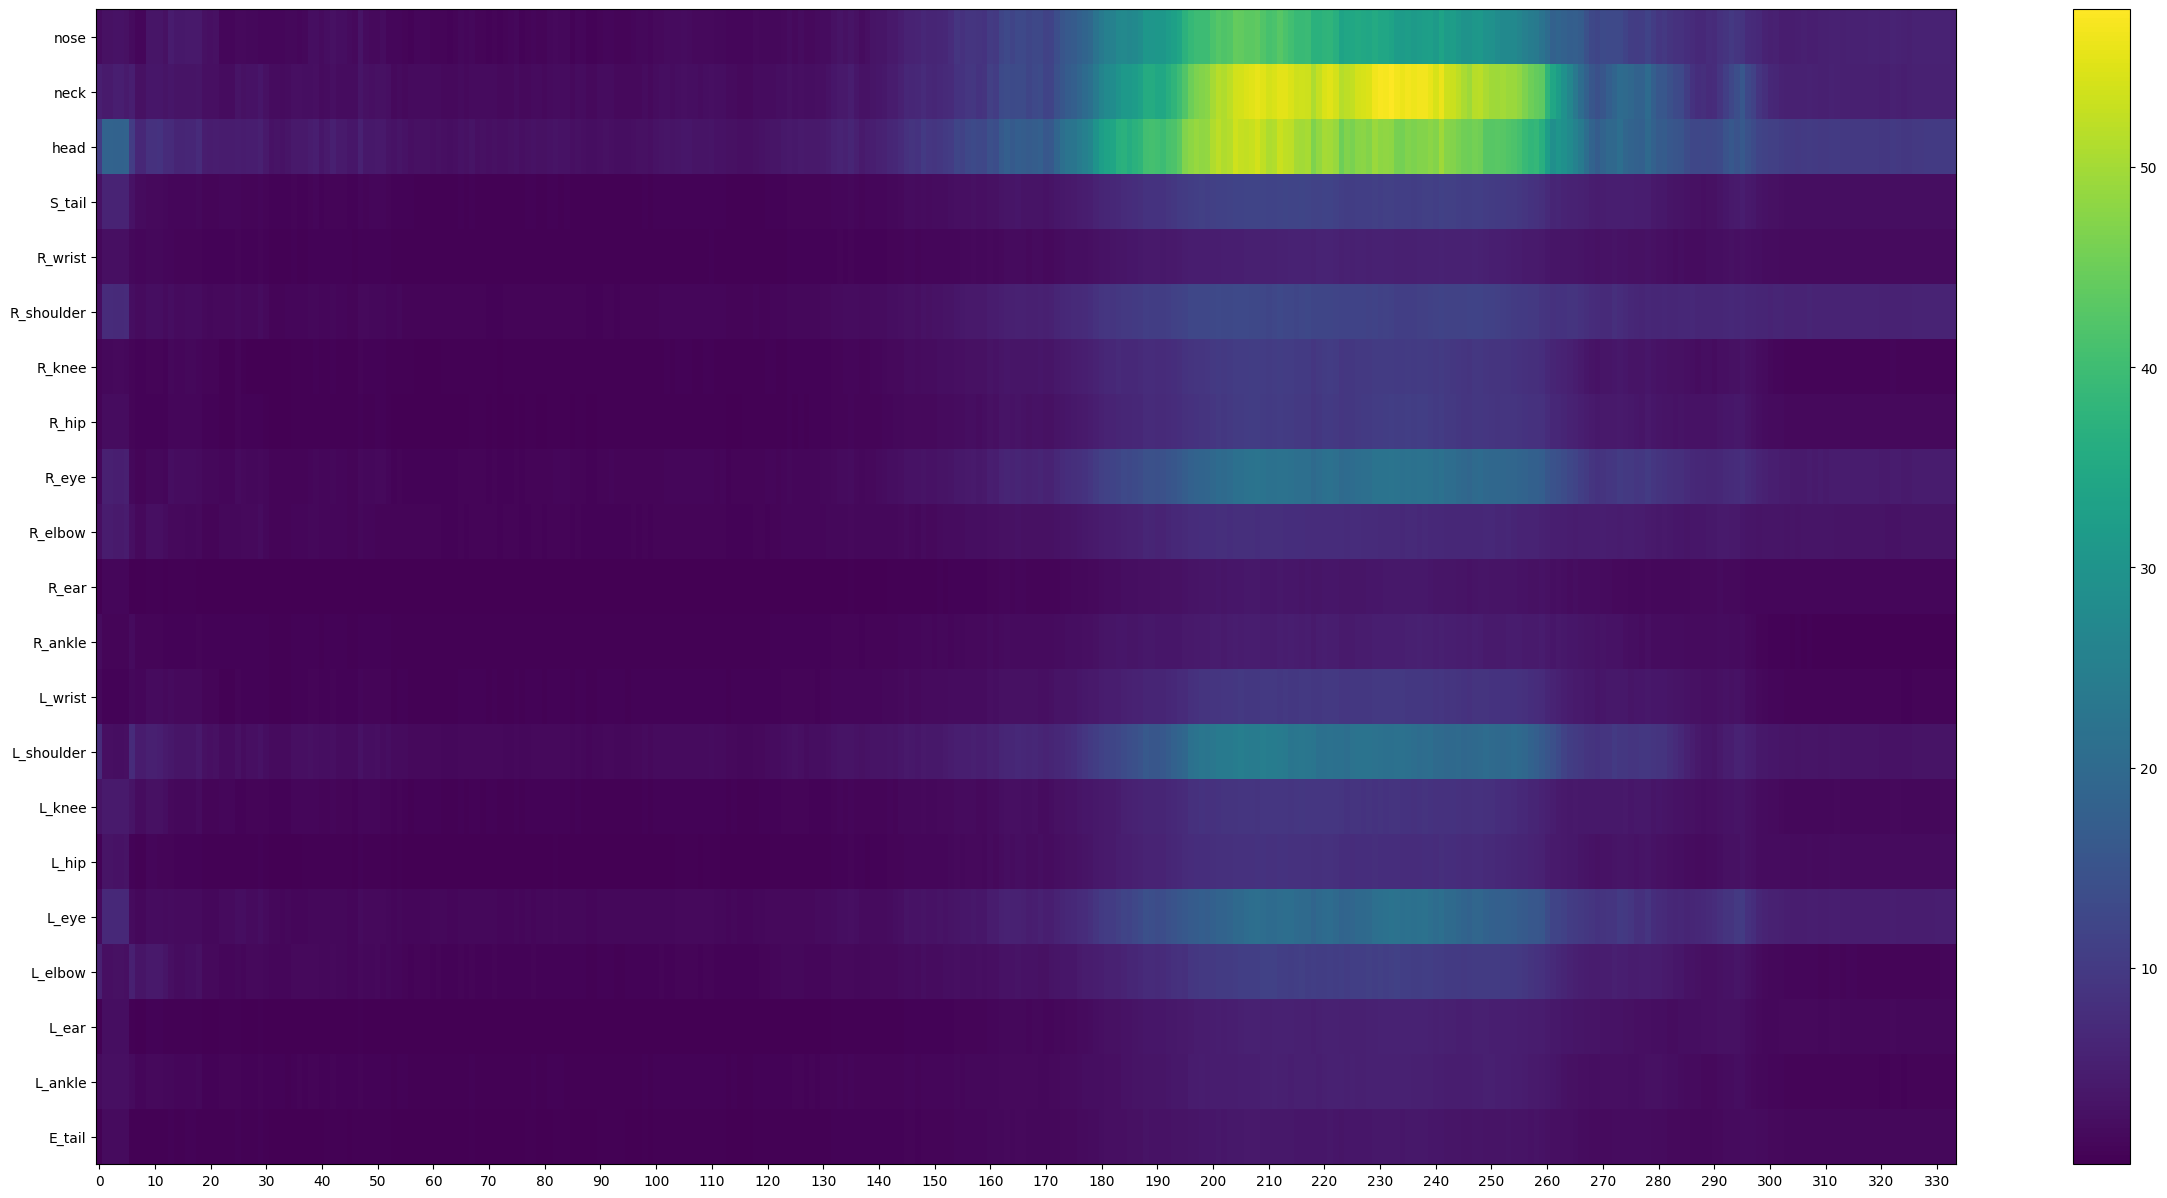

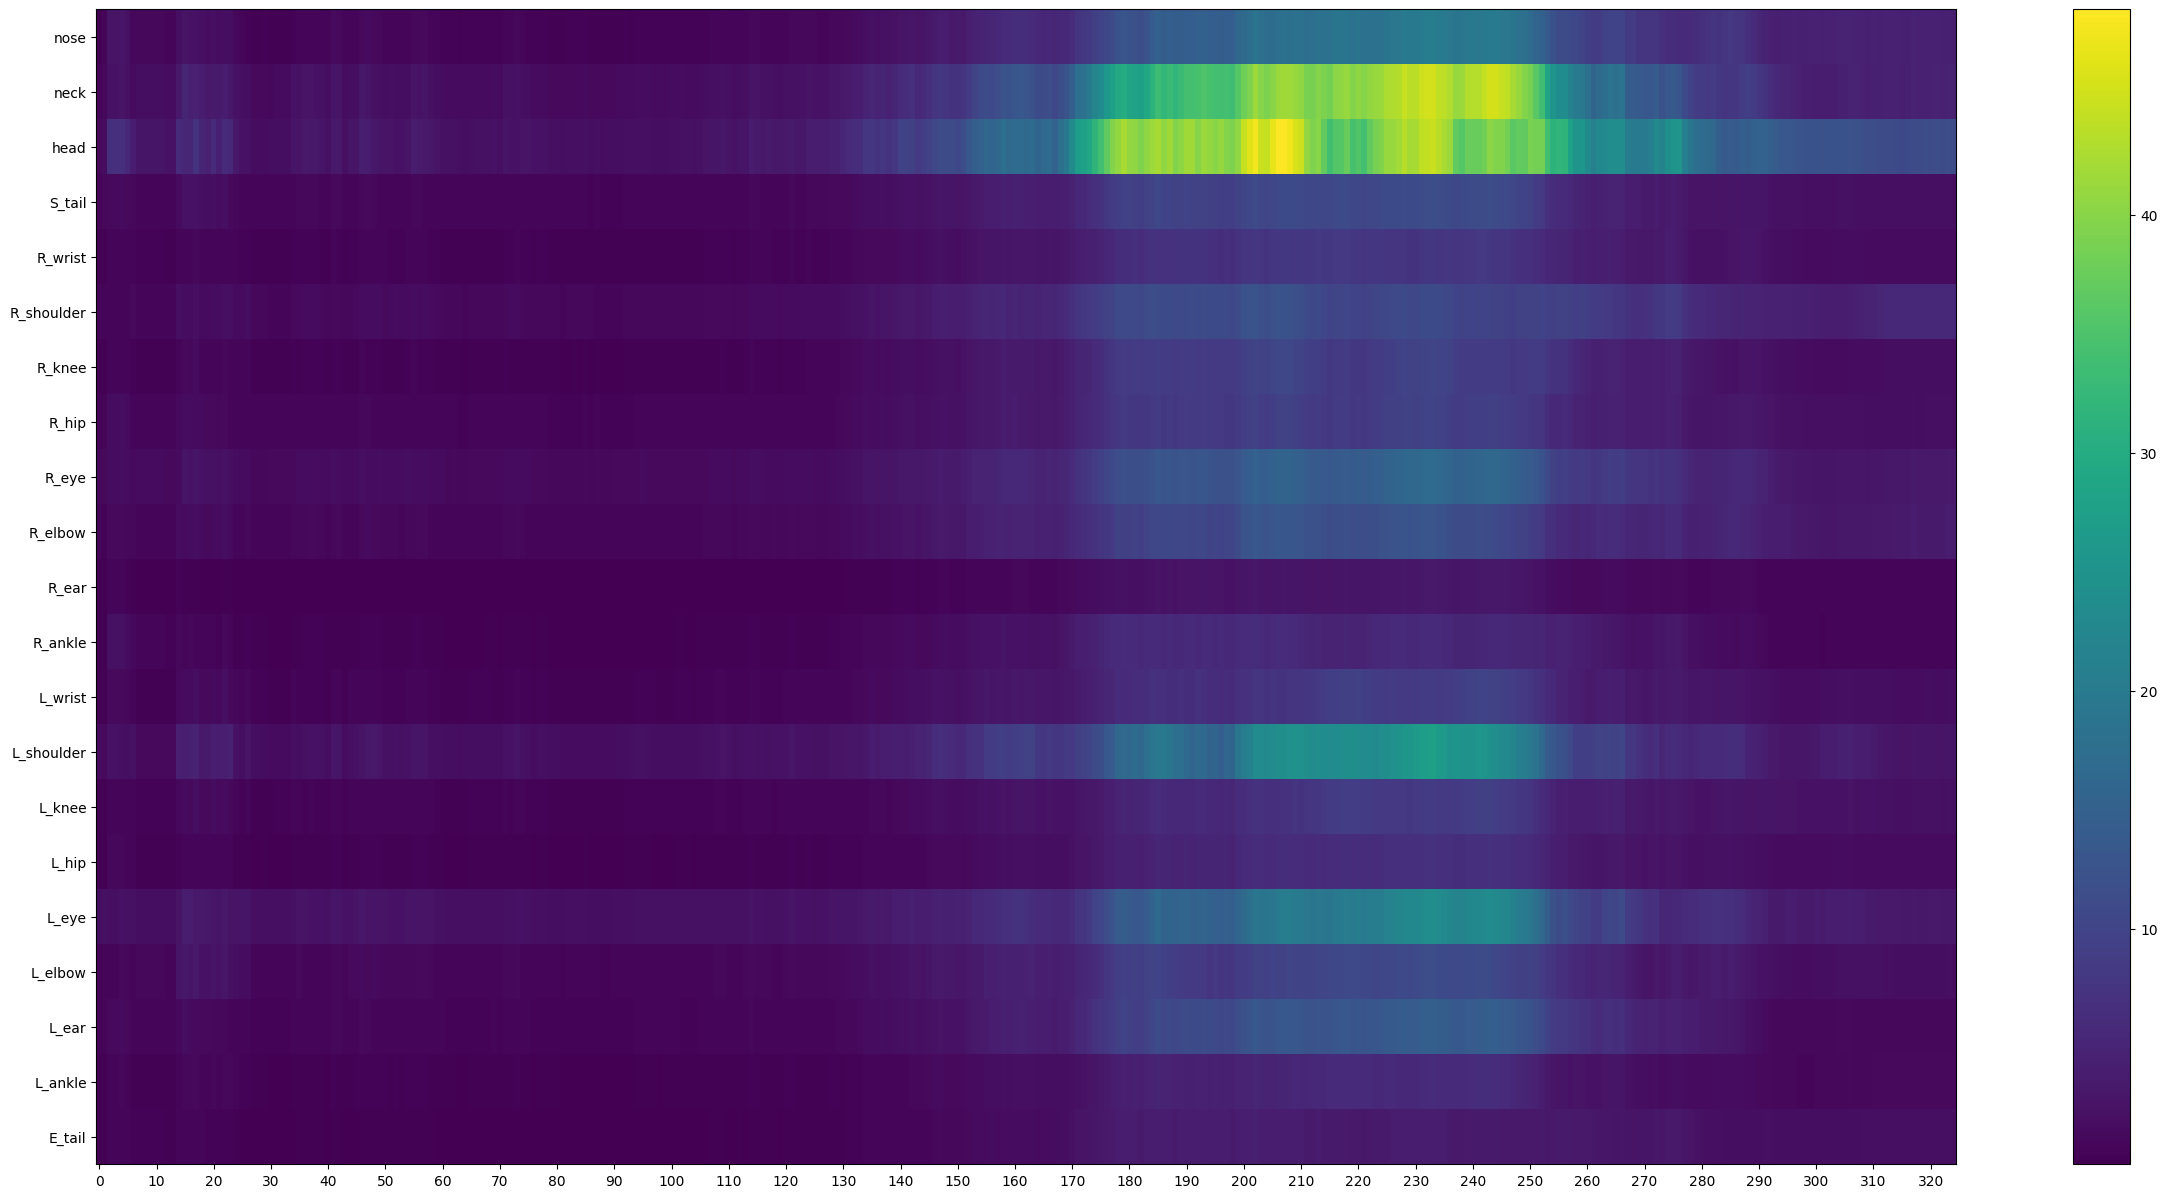

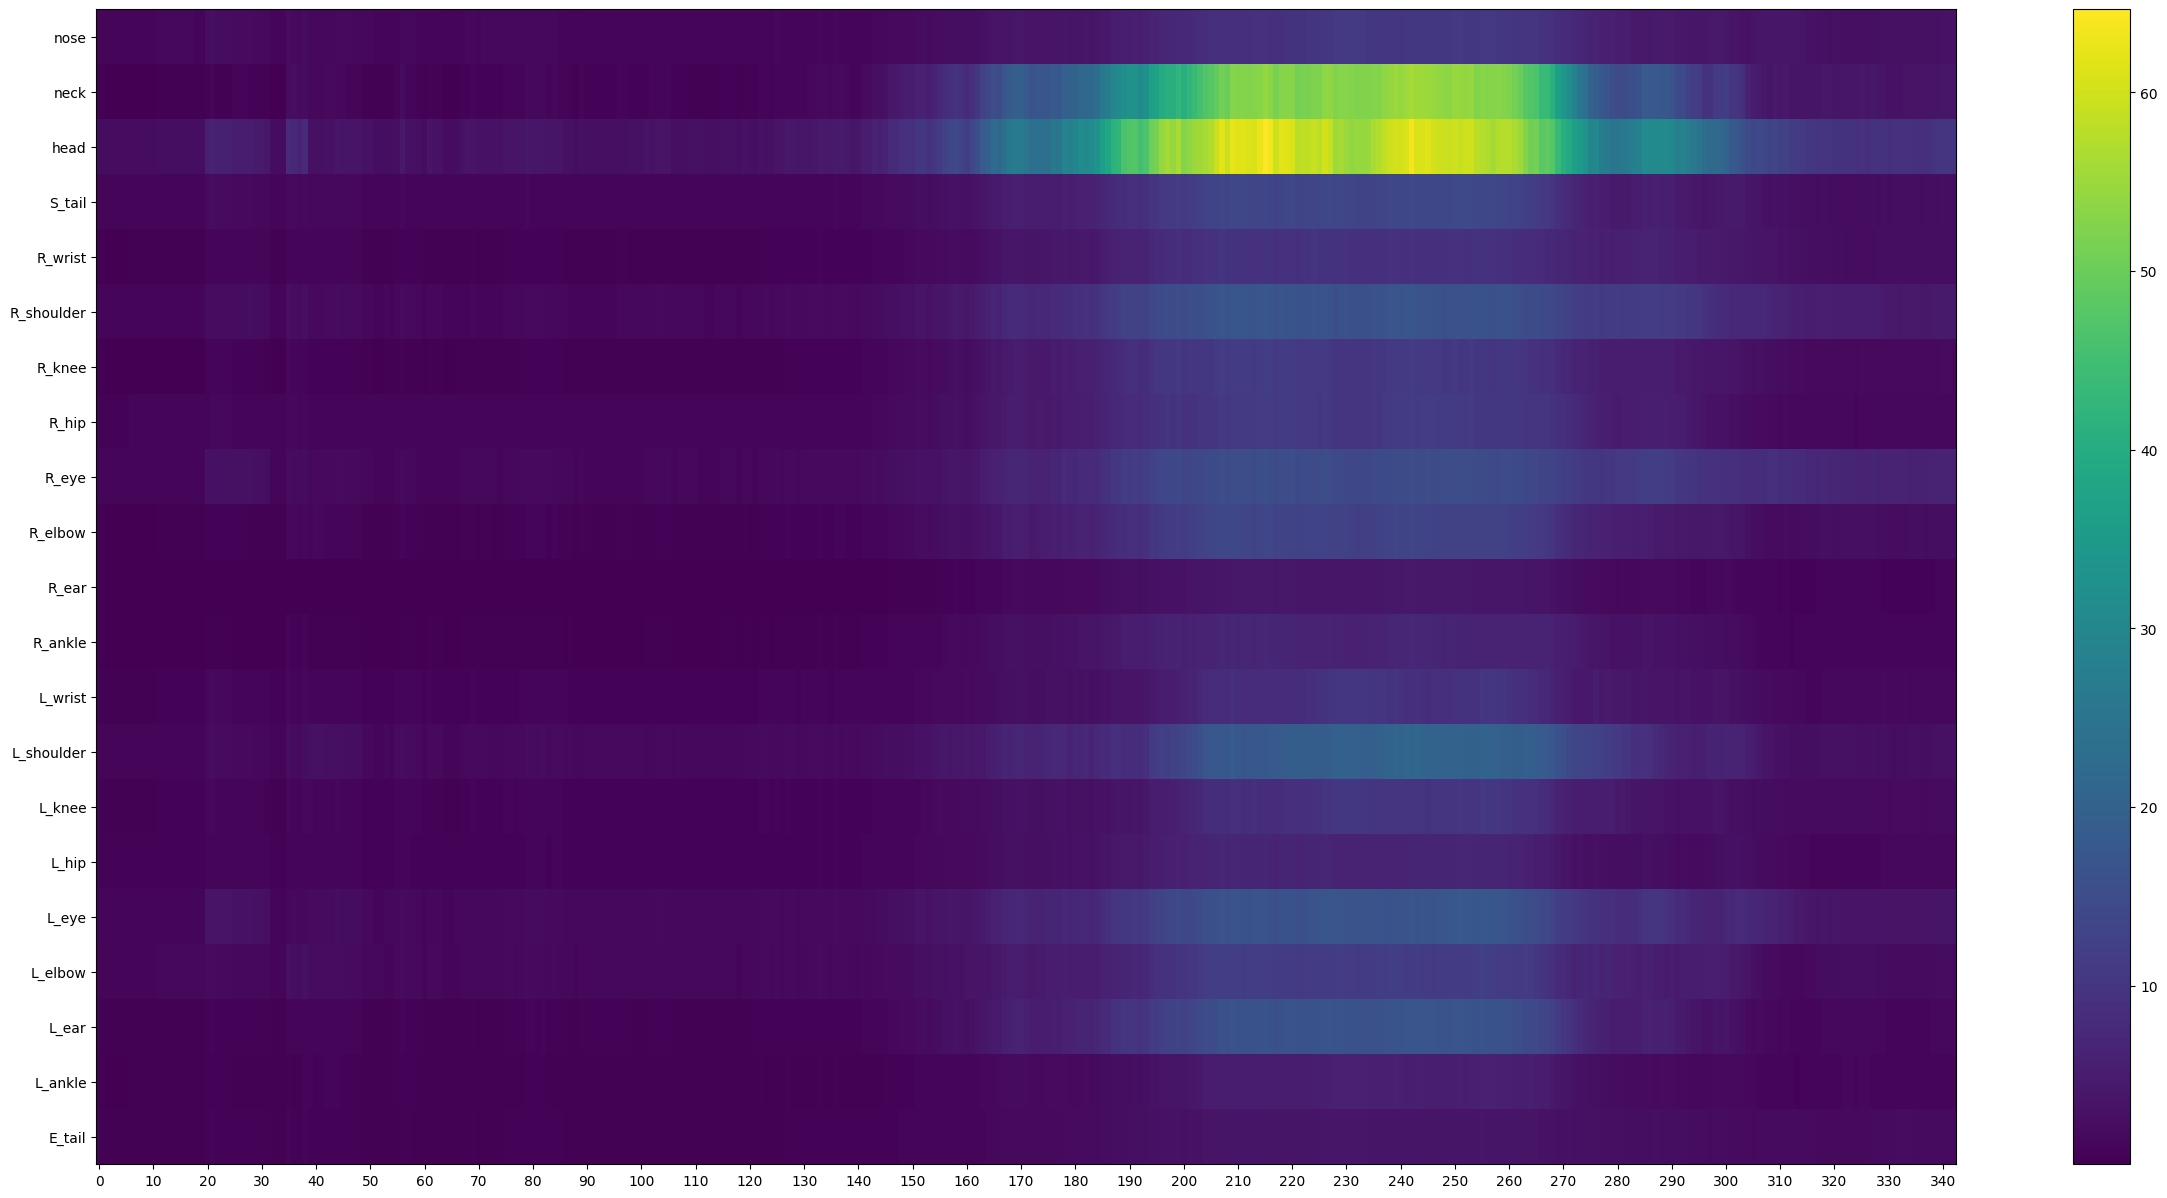

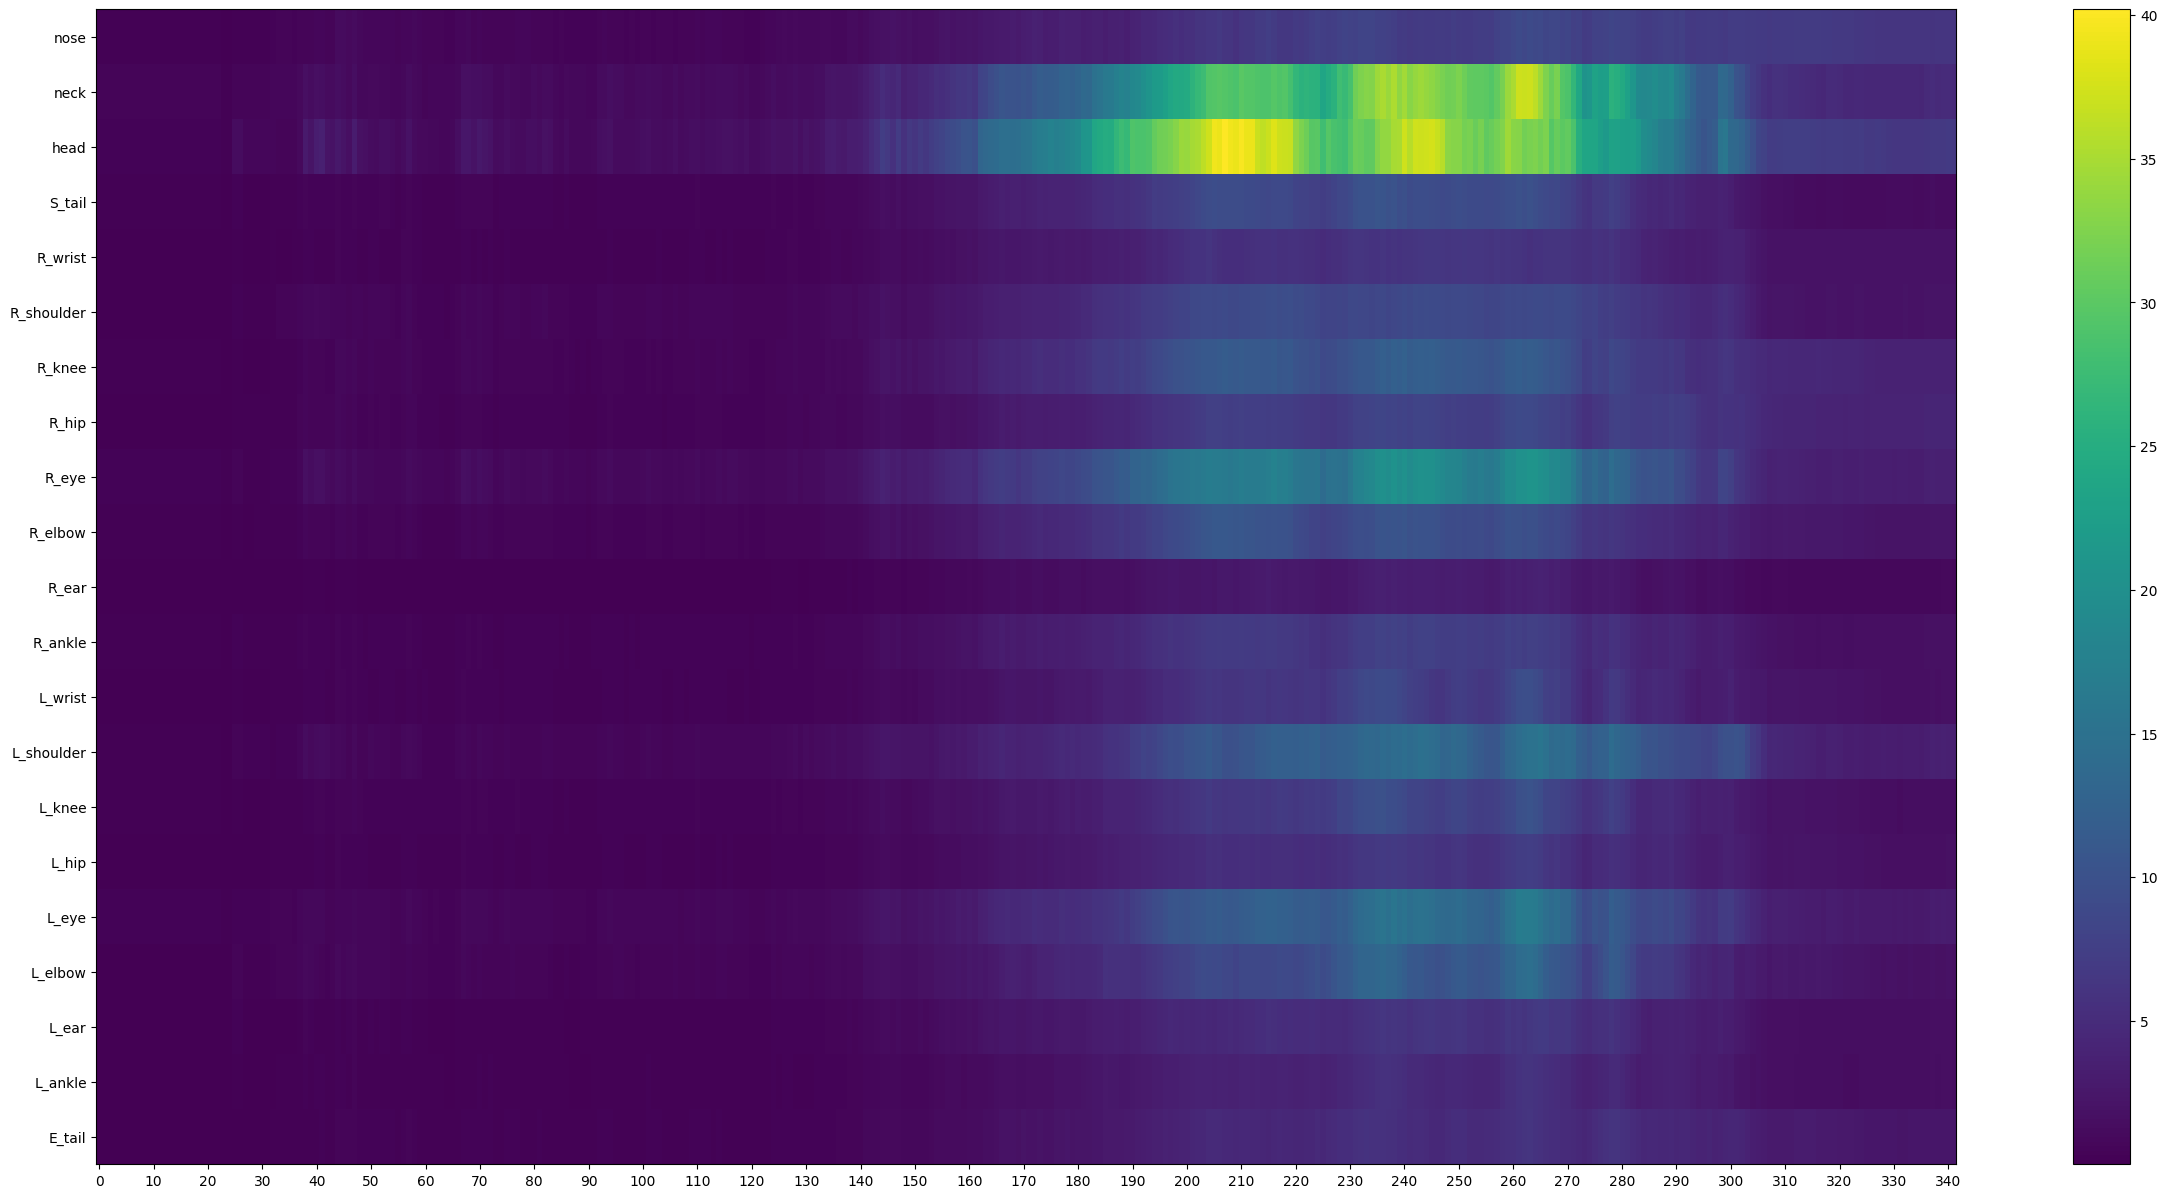

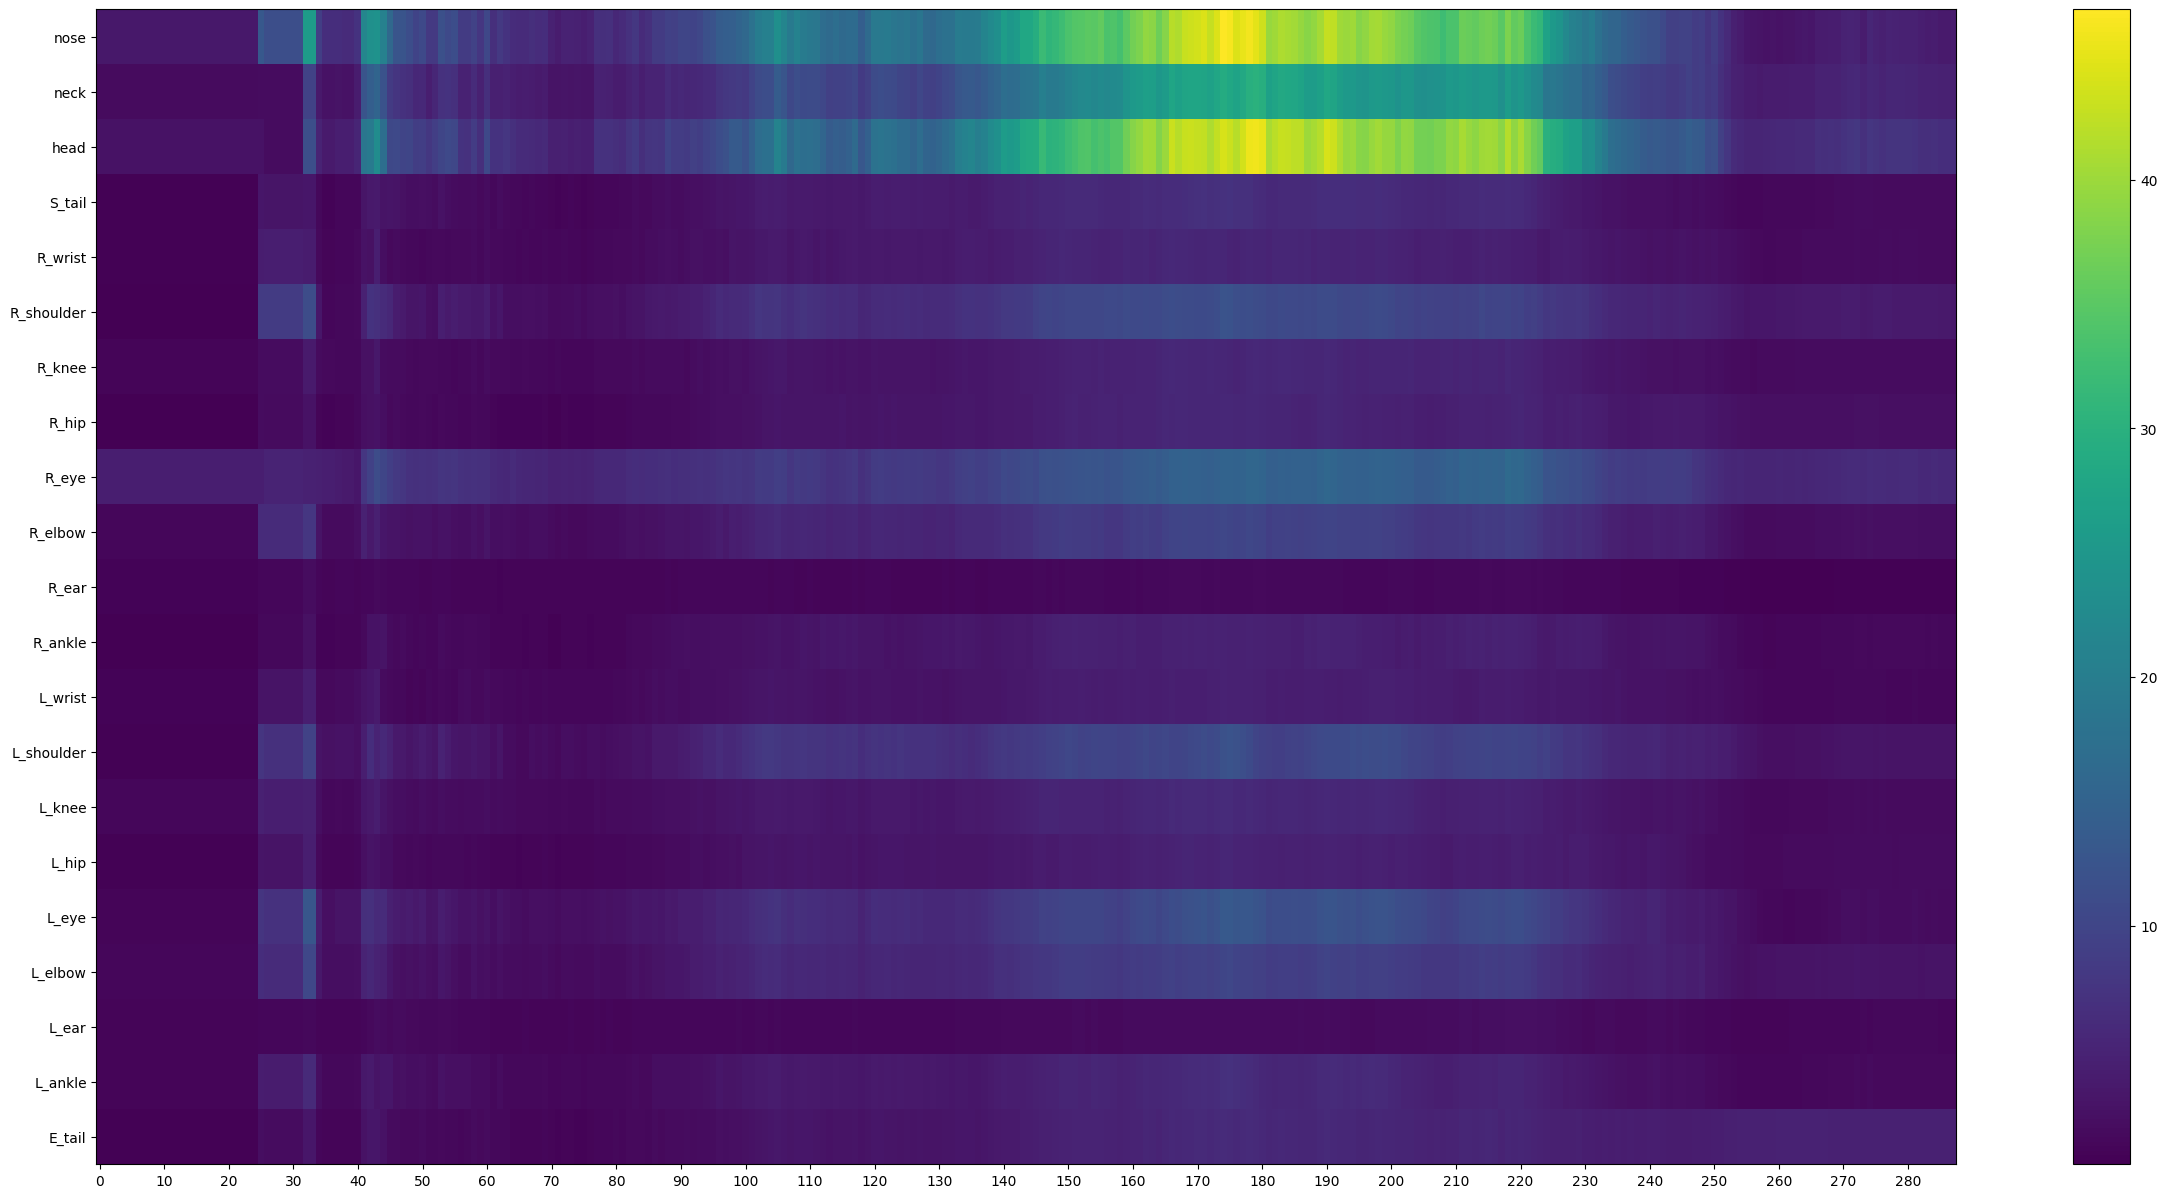

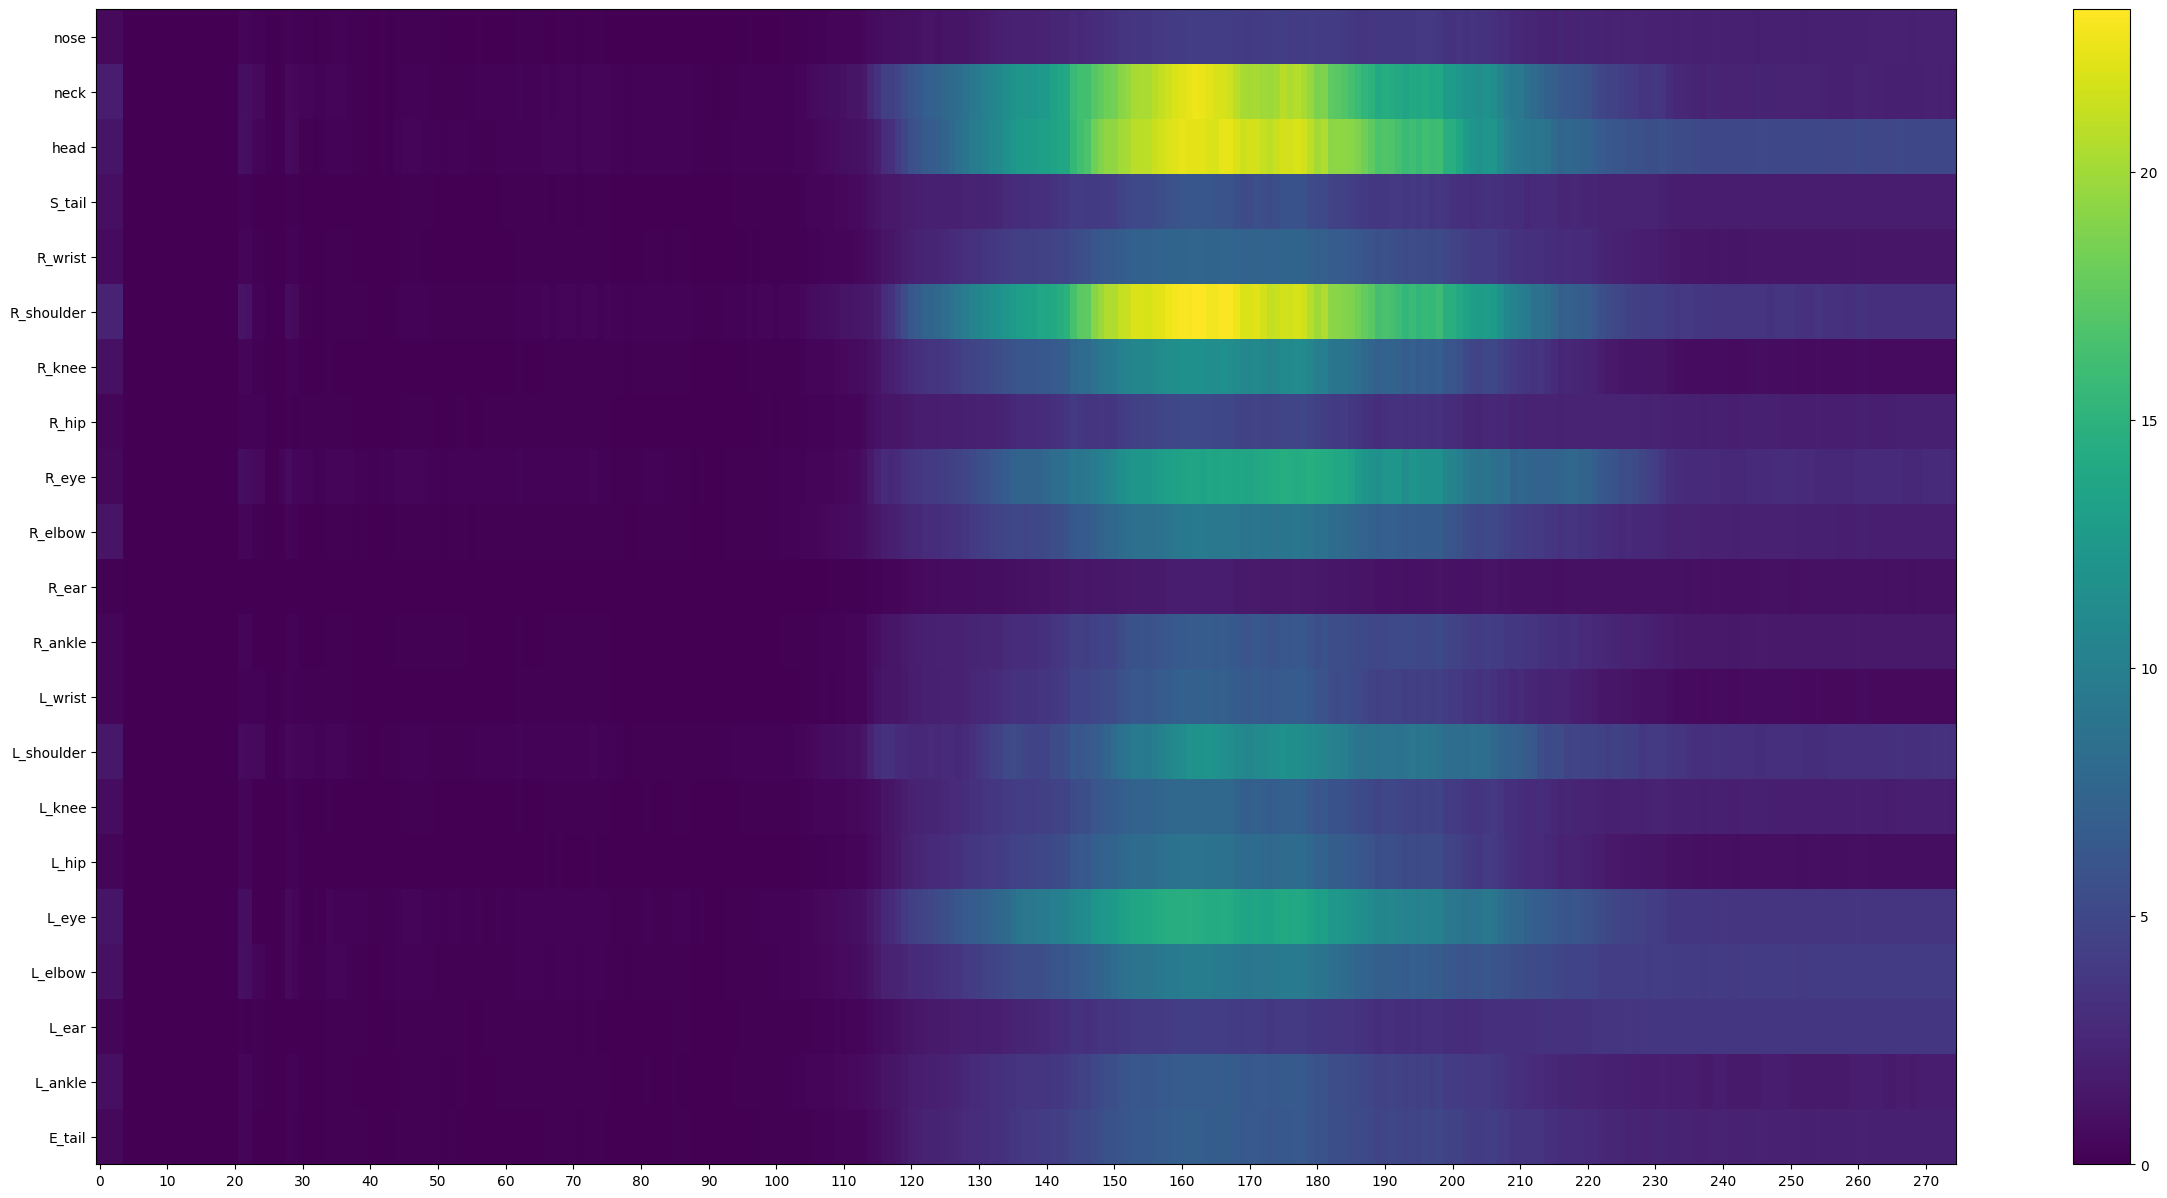

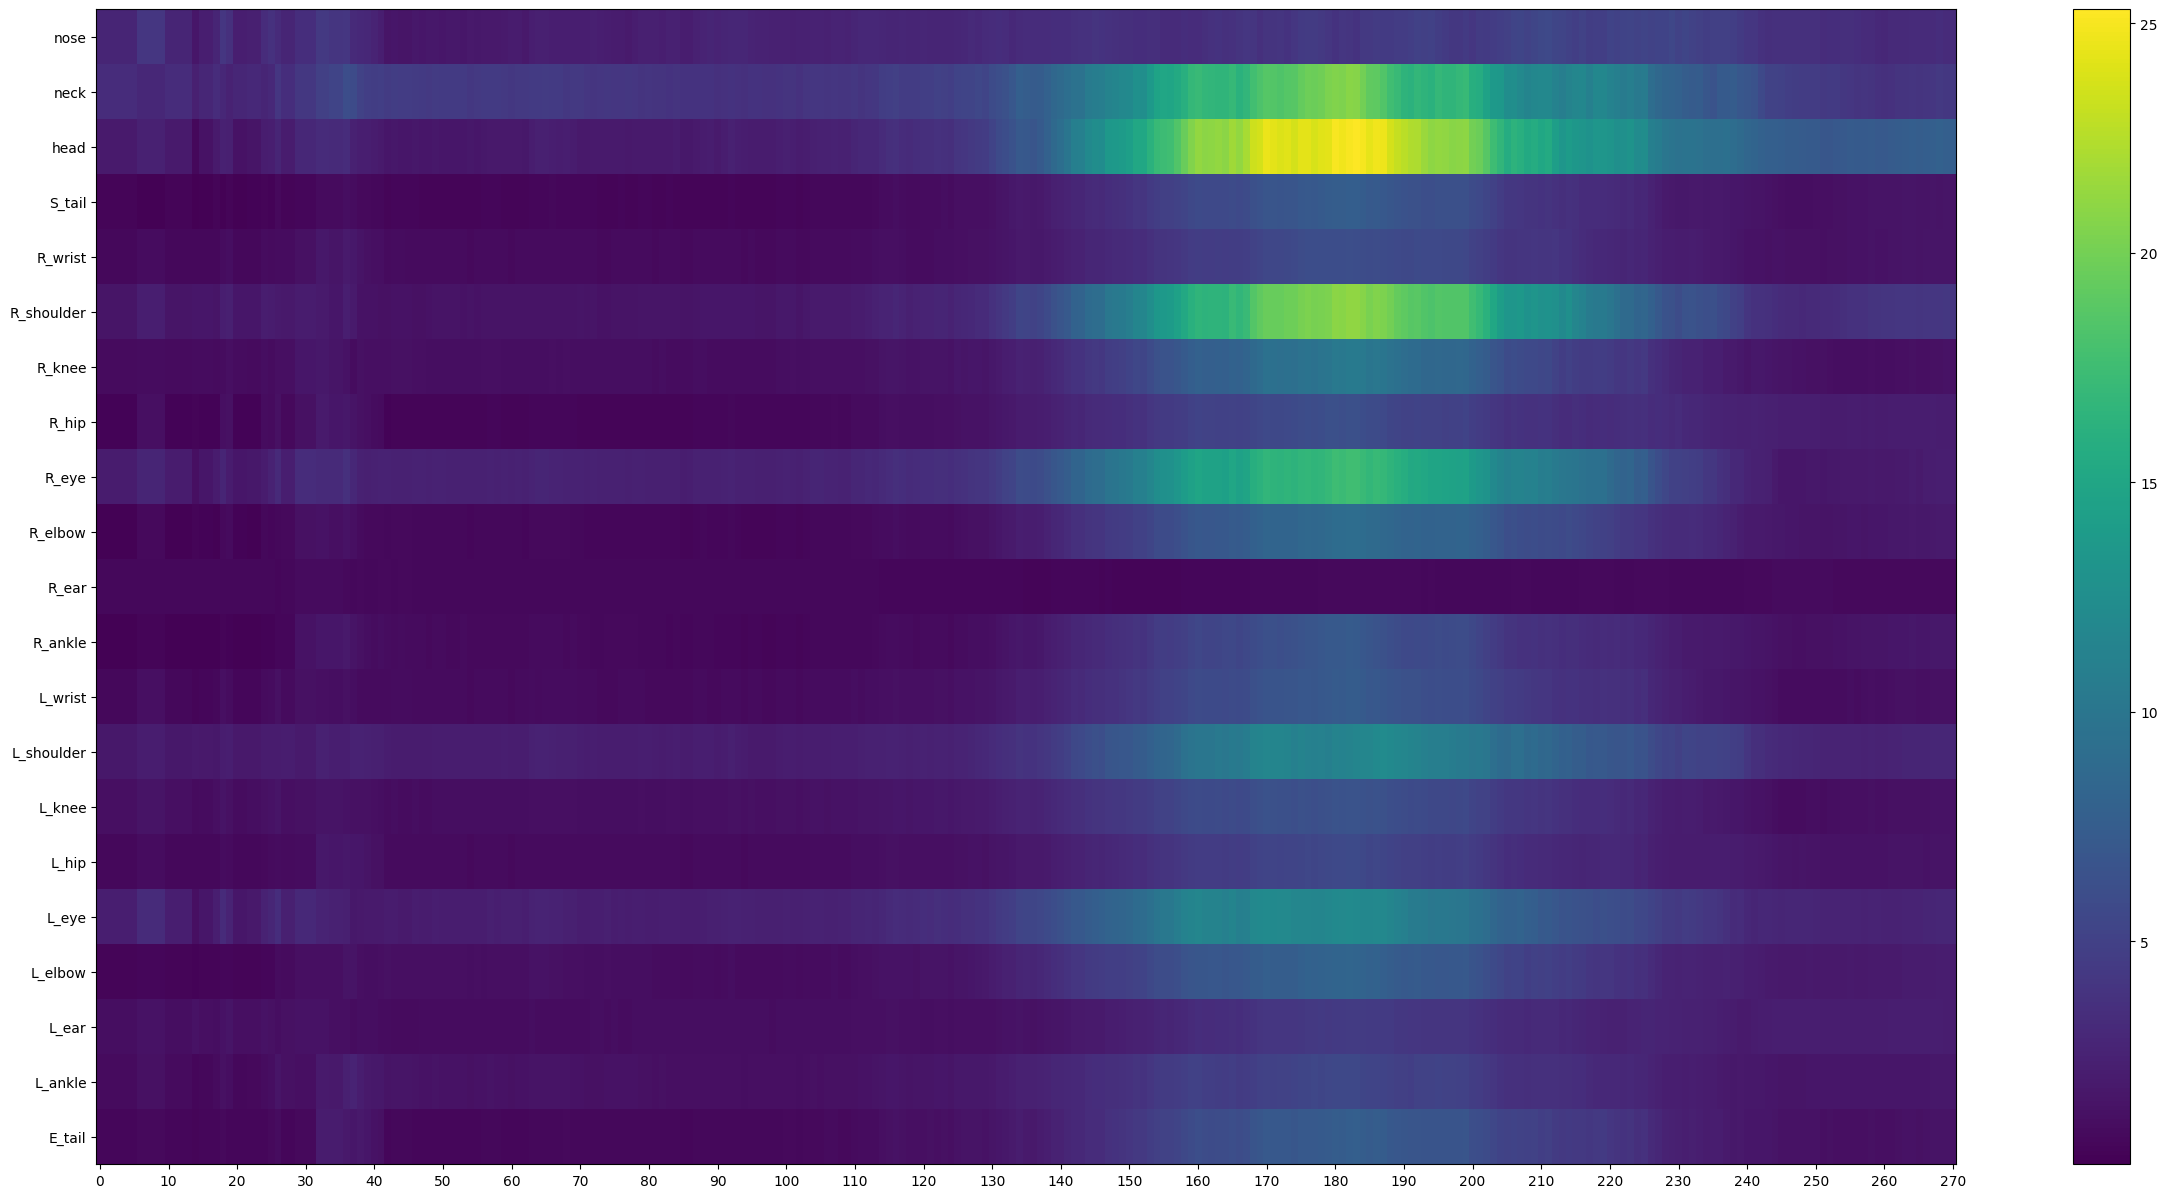

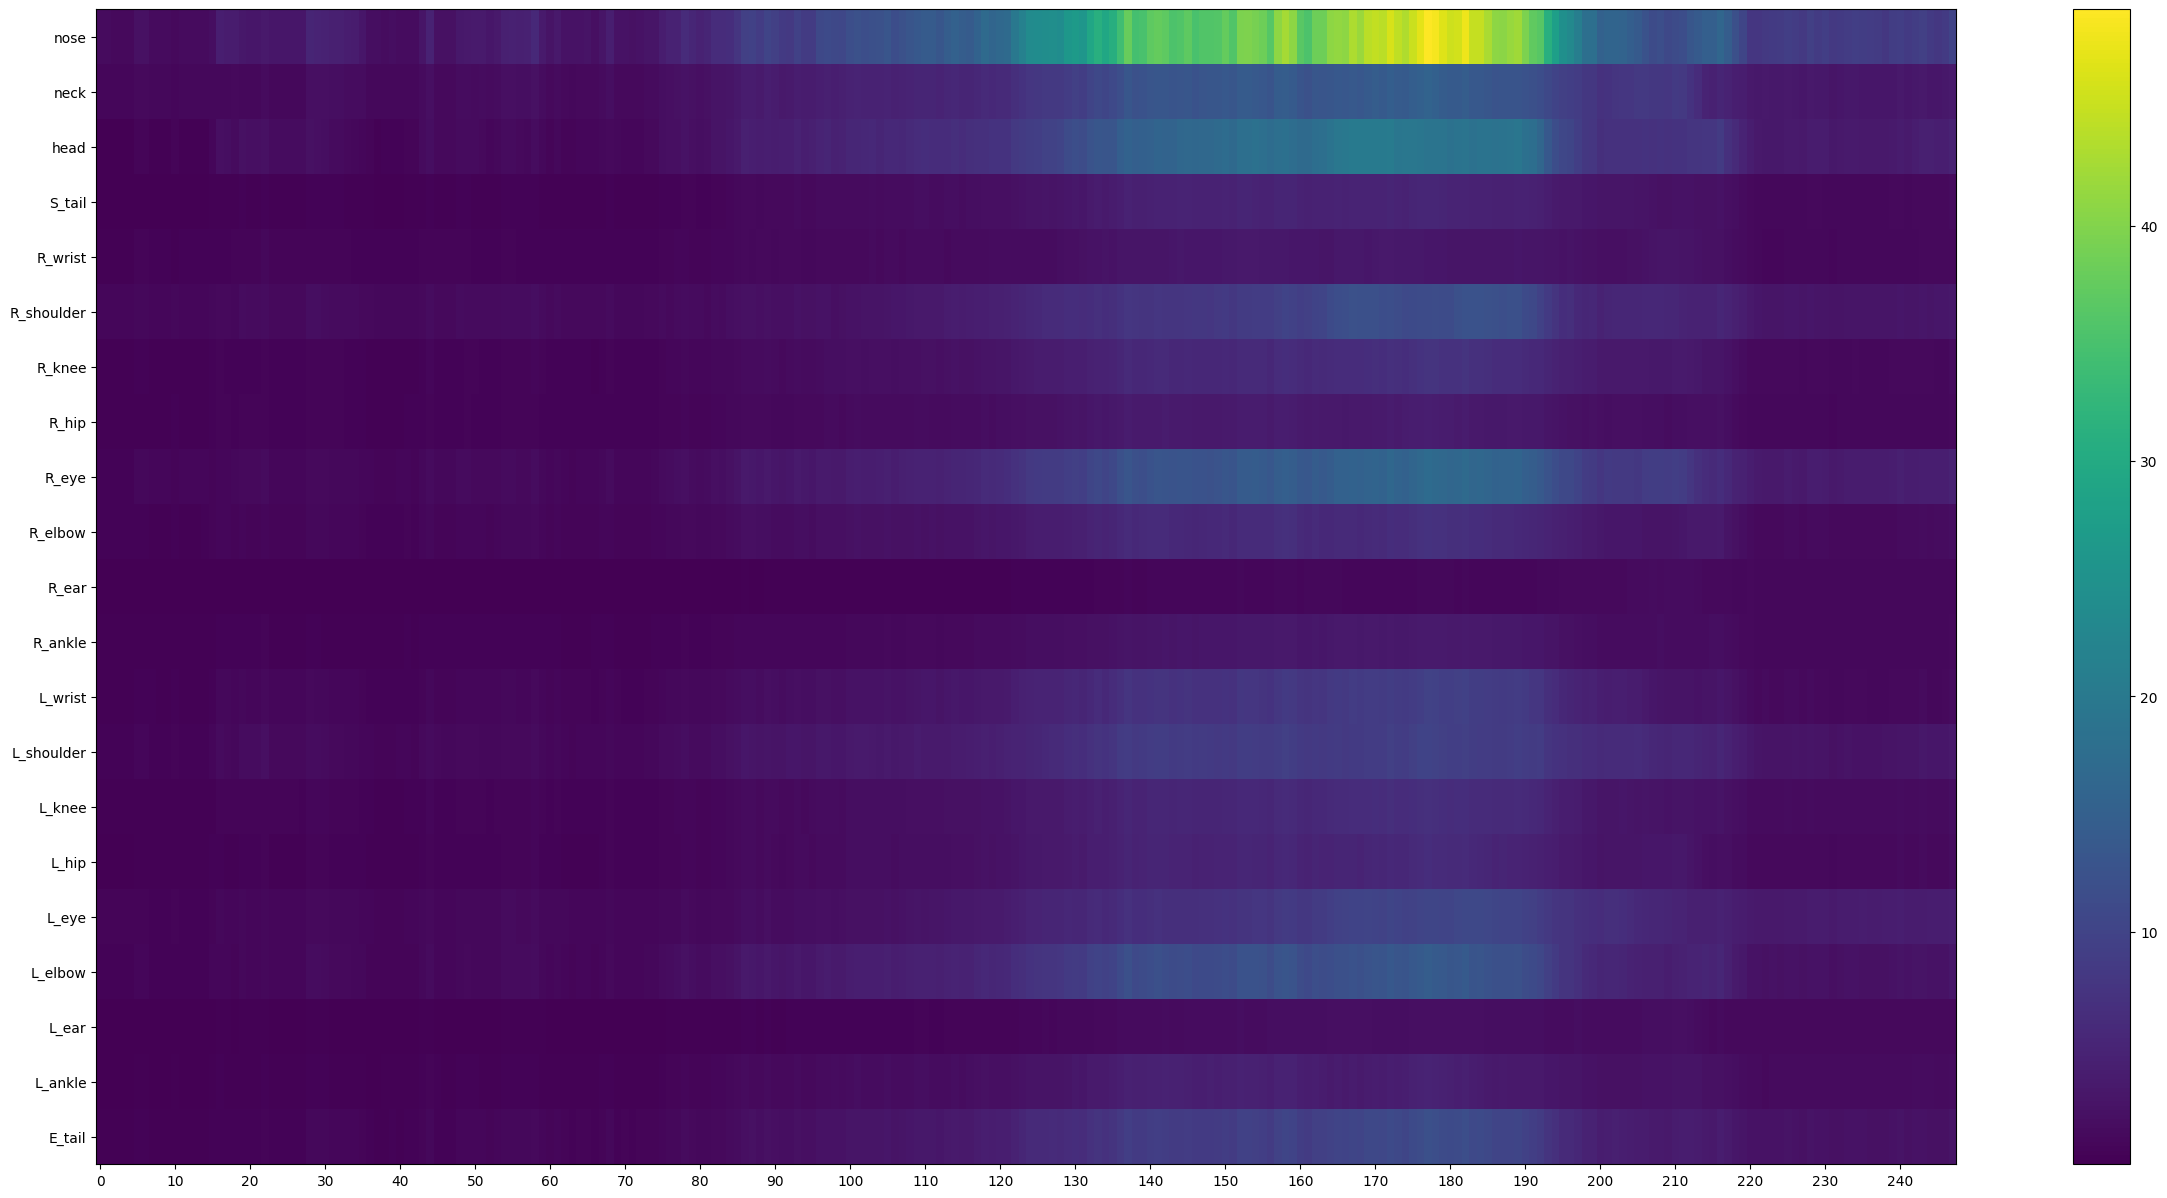

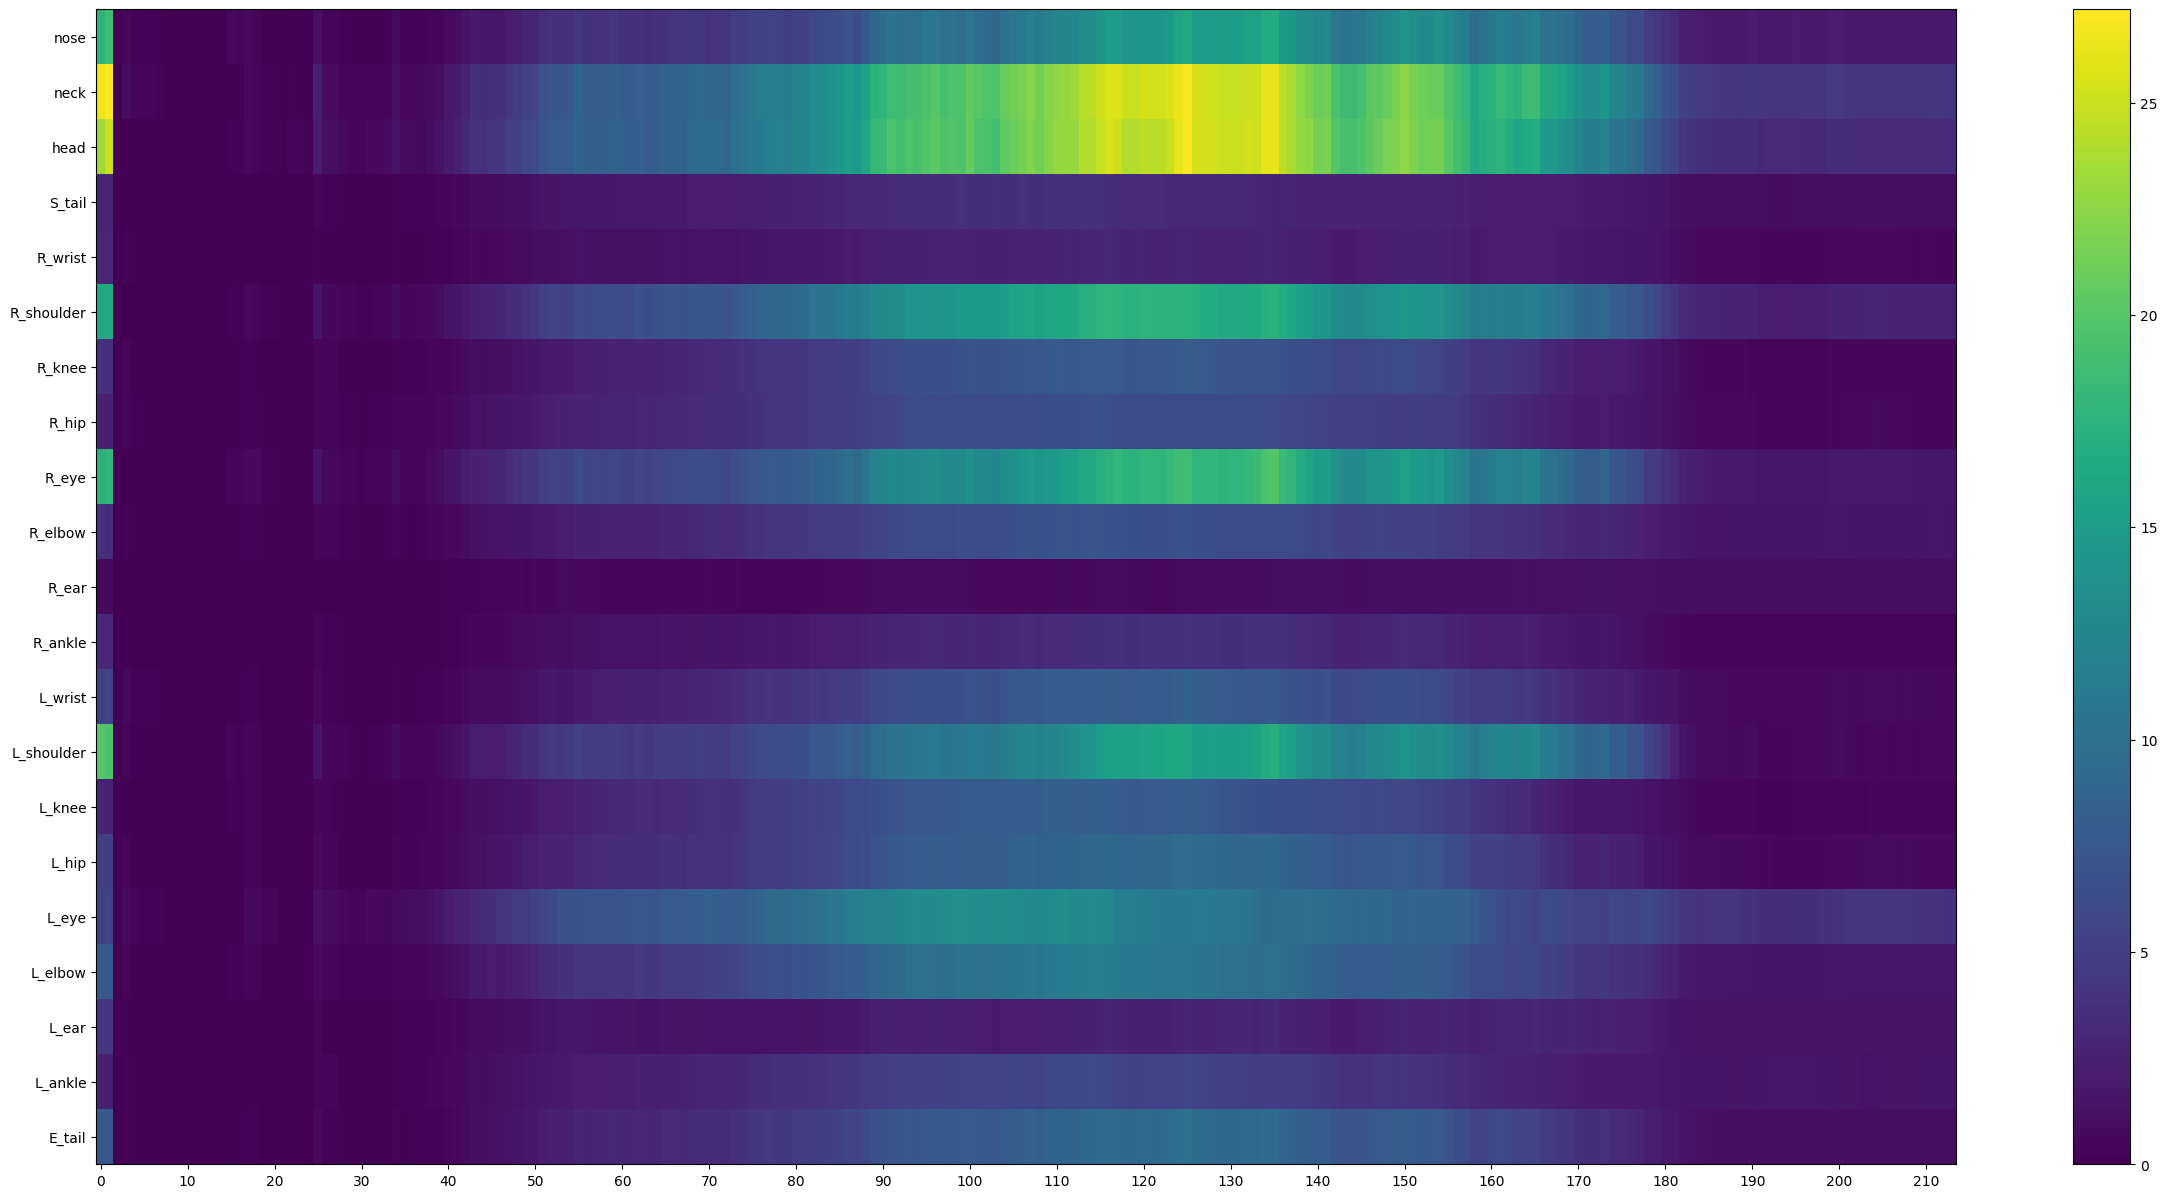

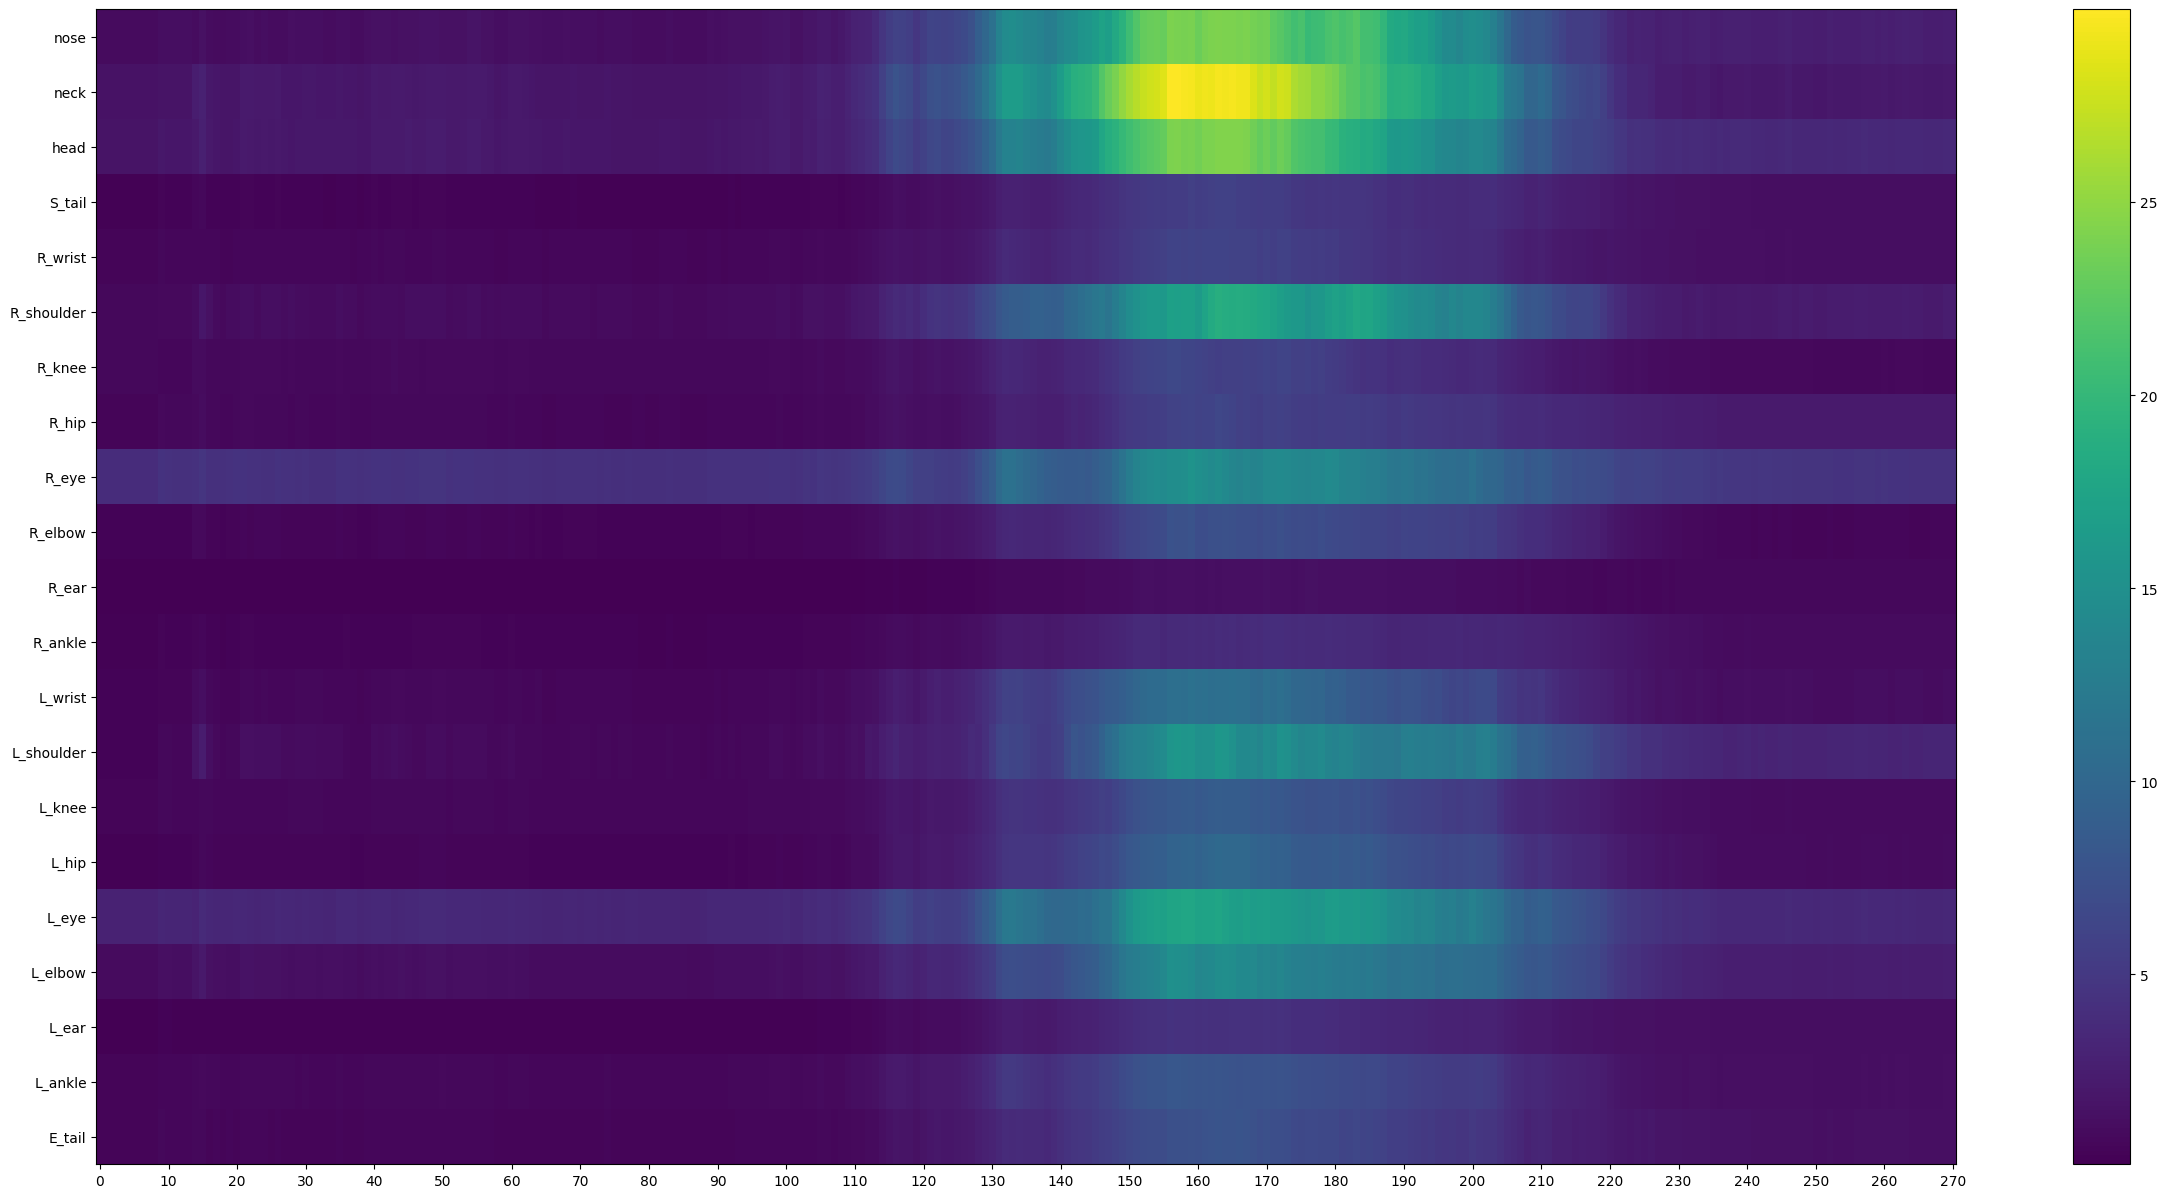

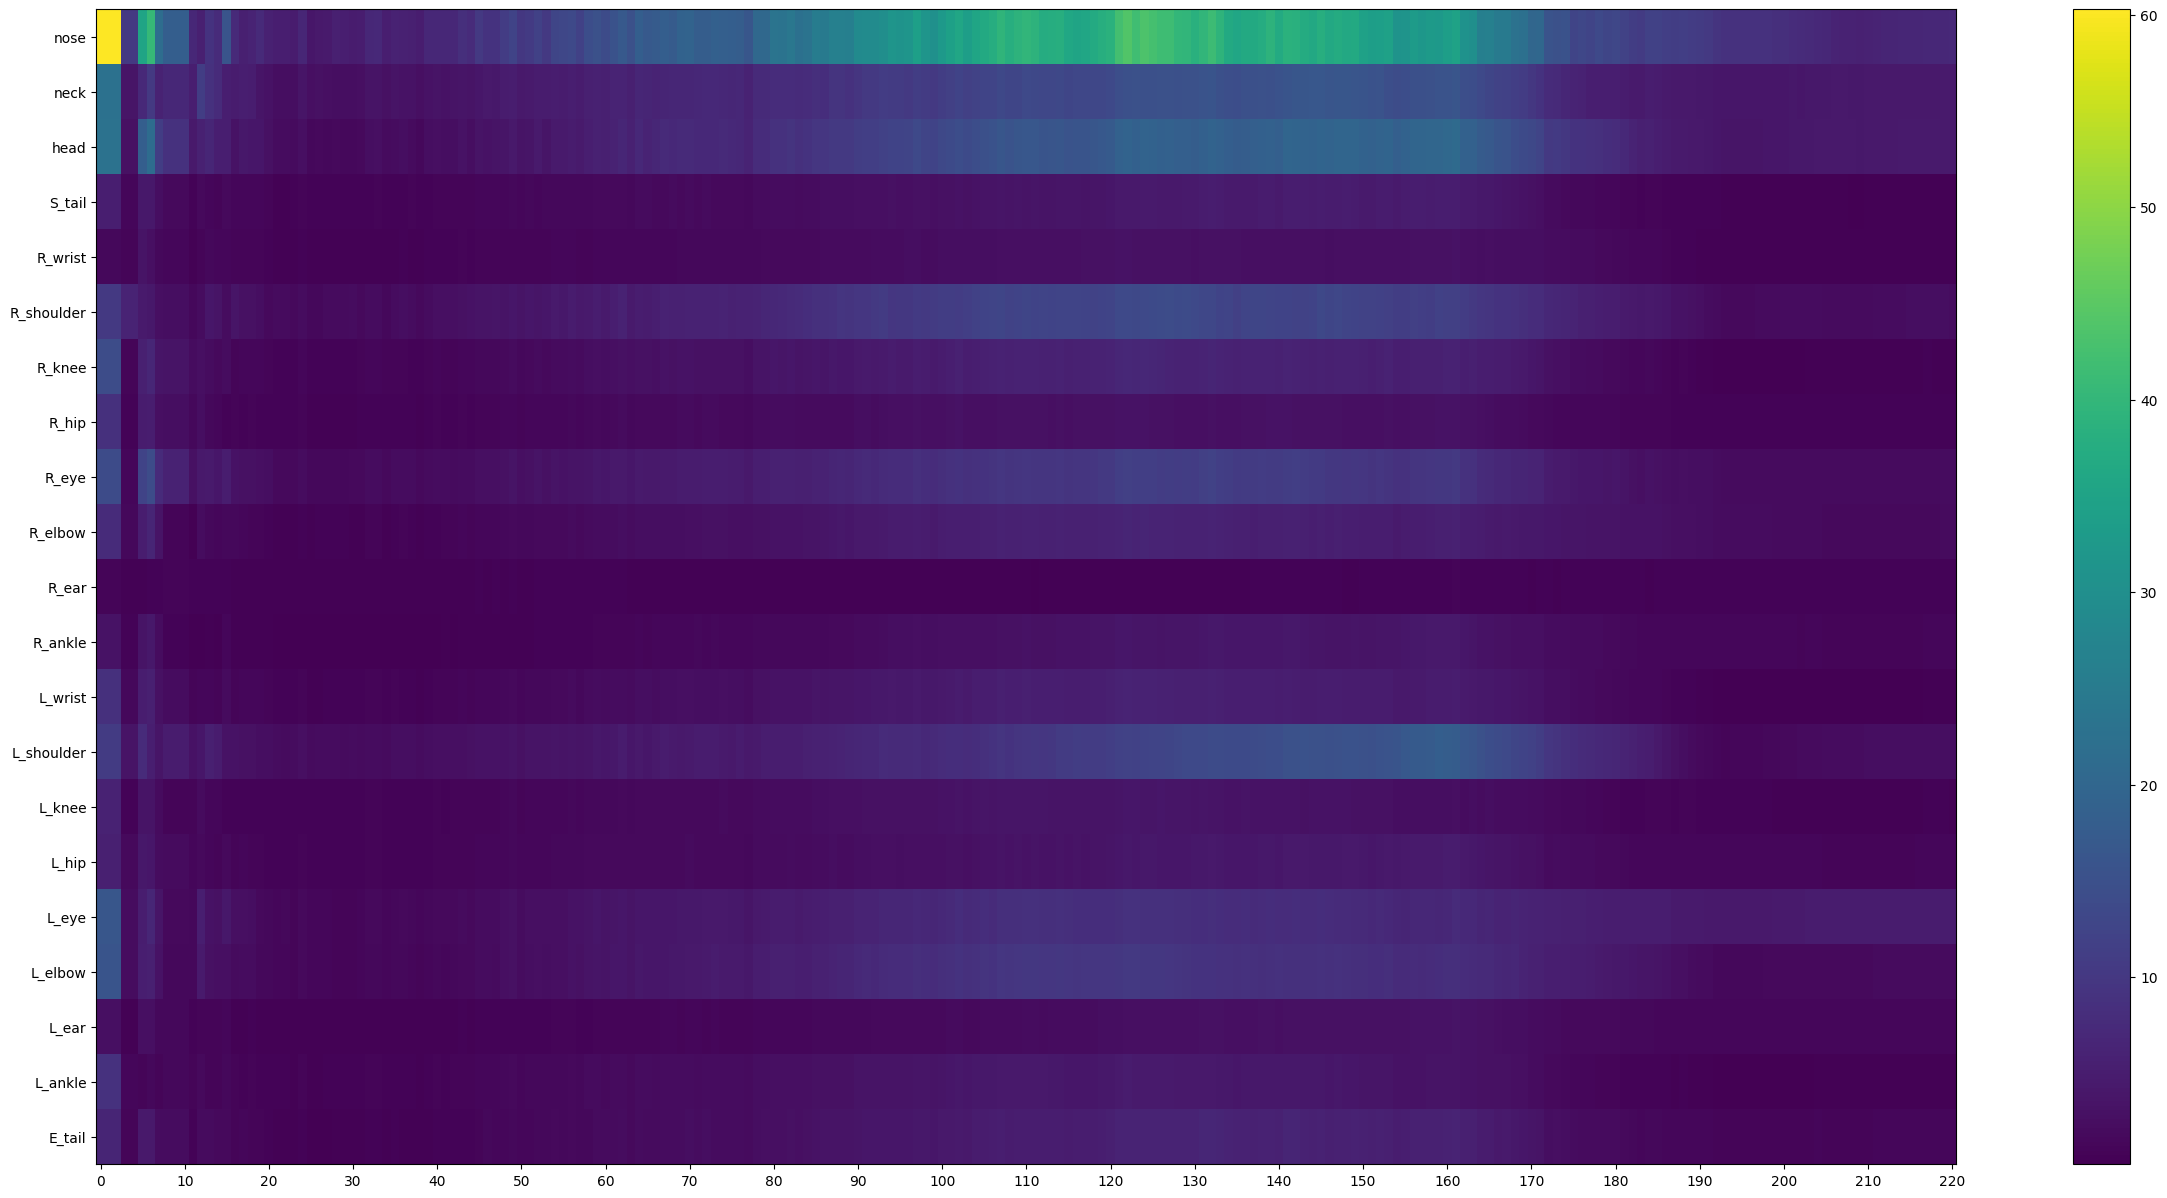

In [243]:
for session in grads:
    max_len = max(trial.shape[1] for trial in grads[session])
    n_trials = len(grads[session])
    padded = np.full((n_trials, 2, max_len, 21), np.nan)
    for i, trial_grad in enumerate(grads[session]):
        importance = np.abs(trial_grad).reshape(2, -1, 21, 3).sum(axis=-1)
        T = importance.shape[1]
        padded[i, :, -T:] = importance  # right-align the trial
    mean_heatmap = np.nanmean(padded, axis=0)

    plt.figure(figsize=(30, 15))
    plt.imshow(
        mean_heatmap[1].T,
        aspect="auto",
        # extent=[0, 4.325, 0, 21],
        origin="lower",
        cmap="viridis",
    )
    plt.xticks(np.arange(0, max_len, 10))
    plt.yticks(
        list(ml.poses.keypoints["gbyk"].values()),
        list(ml.poses.keypoints["gbyk"].keys()),
    )
    plt.colorbar()
    plt.show()
    plt.close()